In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math, re
import matplotlib.pyplot as plt
import torchvision.transforms as tvtransforms

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# MTANN
import MTANN
from torchviz import make_dot
import datasets, transforms

# Settings
image_spatial_size=(512,512)
key_source, key_boneless = "source", "boneless"

# Save path for nets
path_to_save = os.path.join('.')



# Data
switch_set = "external"
if switch_set == "internal":
    discriminator_keys_images = [key_source, key_boneless]
    root_directory = "D:/data/JSRT/"
    path_to_source_images = os.path.join(root_directory, "JSRT")
    path_to_target_images = os.path.join(root_directory, "BSE_JSRT")
    transforms = tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             ])
    test_set = datasets.JSRT_CXR( path_to_source_images, path_to_target_images, 
                   transform=transforms)
if switch_set == "external":
    path_to_source_images_external = "D:/data/POLYU_COVID19_CXR_CT_Cohort1/cxr/CXR_PNG/"
    discriminator_keys_images = [key_source]
    transforms = tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             ])
    test_set = datasets.POLYU_COVID19_CXR_CT_Cohort1(path_to_source_images_external, transform=transforms)

In [6]:
sample = next(iter(test_set))


# Decompose the sample into subregions
preprocessing = MTANN.dataPreprocessing(sample, discriminator_keys_images)

# Networks
netHR, netMR, netLR = MTANN.load_networks(first_layer=81, second_layer=40, path_HR='./netHR.pt', path_MR='./netMR.pt', path_LR='./netLR.pt')
netHR.eval()
netMR.eval()
netLR.eval()

# Initialisation of overlapping subregions setup
reconstruction = MTANN.ImageReconstruction(sample, key_source, key_boneless=None, matrix_size=9, stride=1)
image, image_from_LR , image_from_MR , image_from_HR = reconstruction.reconstruct_multiresolution(netHR, netMR, netLR)
image = (image - np.amin(image))/(np.amax(image) - np.amin(image))

"""LR_image = np.zeros(preprocessing.LR['source'].shape)
side = ovs.matrix_size//2
for ii, data in enumerate(ovs.execute(preprocessing.LR)):
    subregion, _, center_pixel = data
    pixel_output = netLR(subregion)
    LR_image[center_pixel[0]-side , center_pixel[1]-side] = pixel_output"""



"LR_image = np.zeros(preprocessing.LR['source'].shape)\nside = ovs.matrix_size//2\nfor ii, data in enumerate(ovs.execute(preprocessing.LR)):\n    subregion, _, center_pixel = data\n    pixel_output = netLR(subregion)\n    LR_image[center_pixel[0]-side , center_pixel[1]-side] = pixel_output"

1.0


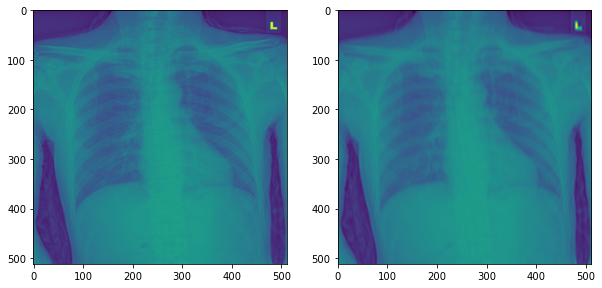

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(sample["source"])
image_composed = 0.1*image_from_LR + 0.4*image_from_MR + 0.5*image_from_HR
ax[1].imshow(image_from_HR)
print(np.amax(image_from_MR/np.amax(image_from_MR)))